<a href="https://colab.research.google.com/github/paucaroscanoa/ApiBookAuthor/blob/master/Caso_de_estudio_6_1_Trayectos_en_taxi_Principiante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de estudio 6.1 - Trayectos en taxi en Nueva York

#### Nota: Si en algún momento cierra este notebook tendrá que volver a ejecutar todas las celdas de nuevo al abrirlo.

#### Nota: Puede que obtenga diferentes resultados numéricos al ejecutar el notebook en diferentes ocasiones. Esto es normal, simplemente entregue los resultados obtenidos.

# PYTHON PRINCIPIANTE

Como esta es la versión para principiantes, se ha incluído la mayor parte del código para ayudarle con el caso.

**Primero, rellene su información de contacto en la celda siguiente. A continuación, únicamente tendrá que escribir las respuestas a las preguntas que se plantean. Para el resto de celdas, simplemente ejecútelas seleccionando el botón de Run, en la parte superior del notebook**


# Informacion del Alumno

In [1]:
# SU NOMBRE Y APELLIDO : MARIO PAUCAR OSCANOA
# SU E-MAIL MITX PRO : INGMARIOPAUCAR@GMAIL.COM

# Configuración

Ejecute (Run) estas celdas para instalar los paquetes necesarios para completar el caso de estudio. Esto podría llevar unos minutos así que sea paciente.

<h1 style="color:red;">ATENCIÓN: Puede que vea errores cuando ejecute las celdas siguientes. Sin embargo, no se preocupe, con tal de que pueda ejecutar la celda de importación de librerías (dos más abajo) y vea el mensaje "Librerías importadas con éxito!" es suficiente y puede continuar con el caso de estudio.<h1>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q featuretools==1.29.0
import featuretools as ft

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


from google.colab import drive
drive.mount('/content/drive')

<h1>Atención:</h1>

Ahora ha de reiniciar el entorno de ejecución. Para ello vaya a:

> Entorno de ejecución > _Reiniciar entorno de ejecución_

en la parte superior de su pantalla. Esto asegurará que sus cambio se han realizado con éxito.


# Importar

Sincronice su cuenta de Google. Para ello, siga el link que aparece en la salida de la siguiente celda una vez ejecutada. Copie el código que le aparece en pantalla e introdúzcalo en la salida de la celda. Una vez vea el mensaje: `Google Drive sincronizado con éxito!` puede continuar ejecutando el resto de celdas.

In [4]:
from google.colab import auth
auth.authenticate_user()

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
data_drop = drive.CreateFile({'id':'10aXz56ohVOgF2gH4yvmrvTJFY990RHZ1'})
data_drop.GetContentFile('dropoff_neighborhoods.csv')
data_pick = drive.CreateFile({'id':'1zakjpcMUZTKanSeVlPWbYhL85zn5g8zX'})
data_pick.GetContentFile('pickup_neighborhoods.csv')
data_trips = drive.CreateFile({'id':'1D4OJPulDK-Z5l4mgwuI2C1zBr4JRC-Q5'})
data_trips.GetContentFile('trips.pkl')
utils_file = drive.CreateFile({'id':'1UbV2z7L5vonCz3KFLywGs4U-p2g5gQwy'})
utils_file.GetContentFile('utils.py')

print('Google Drive sincronizado con éxito!')

Google Drive sincronizado con éxito!


Importe las librerías necesarias para el desarrollo del caso.

In [5]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     IsWeekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)
%matplotlib inline

print('Bibliotecas importadas com suceso!')

Bibliotecas importadas com suceso!


# Datos

Cargue la base de datos de trayectos de taxi en NYC. Esto podría llevar unos minutos, así que sea paciente.

In [6]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
print(trips.head(10))
print('Datos cargados con éxito!')

       id  vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0  514030          2 2016-04-02 00:00:00 2016-04-02 00:17:00                1   
1  514031          1 2016-04-02 00:00:00 2016-04-02 00:24:00                2   
2  514032          1 2016-04-02 00:00:00 2016-04-02 00:19:00                1   
3  514033          2 2016-04-02 00:00:00 2016-04-02 00:01:00                1   
4  514034          1 2016-04-02 00:01:00 2016-04-02 00:58:00                2   
5  514035          1 2016-04-02 00:01:00 2016-04-02 00:09:00                2   
6  514036          1 2016-04-02 00:01:00 2016-04-02 00:05:00                1   
7  514037          1 2016-04-02 00:01:00 2016-04-02 00:20:00                1   
8  514038          1 2016-04-02 00:01:00 2016-04-02 00:10:00                1   
9  514039          1 2016-04-02 00:01:00 2016-04-02 00:17:00                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.46        -73.987595

También podemos generar algunos gráficos sobre algunos aspectos de los datos para conseguir una mejor idea de sus distribuciones. Por ejemplo, aquí se muestra la variable `trip_duration` (duración del trayecto) que vamos a intentar predecir.

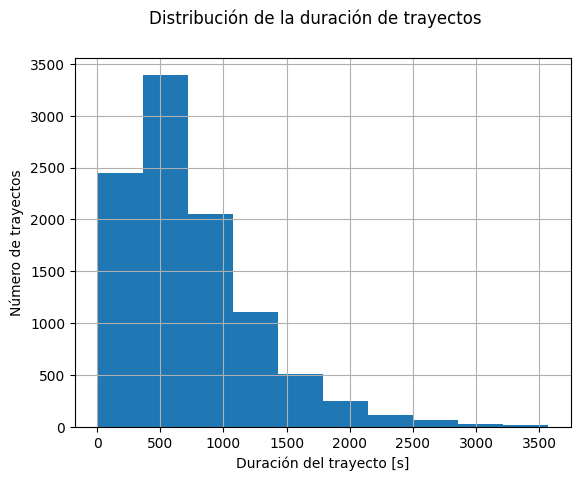

Histograma generado con éxito!


In [7]:
trips.trip_duration.hist()
plt.xlabel('Duración del trayecto [s]')
plt.ylabel('Número de trayectos')
plt.suptitle('Distribución de la duración de trayectos')
plt.show()
print('Histograma generado con éxito!')

Histograma se encuentra visible. Es importante revisar y validar aquellos datos atipicos con duración de trayecto de 2 segundos.

In [8]:
trips.shape[0]  # Muestra la duracion del total de los trayectos mediante distribución en grafica.

10000

In [9]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I


In [10]:
trips.describe()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,10000.00000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,519029.50000,1.527400,2016-04-02 19:38:41.568000,2016-04-02 19:51:07.368000,1.698100,2.743312,-73.976702,40.749273,-73.974212,40.750304,746.098900
min,514030.00000,1.000000,2016-04-02 00:00:00,2016-04-02 00:01:00,1.000000,0.000000,-74.027252,40.632393,-74.027252,40.630280,2.000000
25%,516529.75000,1.000000,2016-04-02 11:56:00,2016-04-02 12:08:00,1.000000,1.000000,-73.992891,40.733330,-73.992287,40.732718,364.000000
50%,519029.50000,2.000000,2016-04-02 19:34:00,2016-04-02 19:48:00,1.000000,1.700000,-73.983452,40.750420,-73.981422,40.752056,616.000000
75%,521529.25000,2.000000,2016-04-03 02:32:00,2016-04-03 02:45:00,2.000000,3.200000,-73.968937,40.766482,-73.962952,40.768576,988.000000
max,524029.00000,2.000000,2016-04-03 14:58:00,2016-04-03 15:54:00,6.000000,32.090000,-73.773987,40.849663,-73.776260,40.849686,3573.000000
std,2886.89568,0.499274,NaN,NaN,1.303045,3.134647,0.032755,0.027119,0.031928,0.030314,525.049496


**<h1>PREGUNTA 1: ANÁLISIS DE DATOS</h1>**

Describa la base de datos. ¿Cuántos trayectos hay en la base de datos? ¿Cómo describiría la distribución de la duración de los trayectos? ¿Hay algo que debamos observar? Asegúrese de que el histograma se muestra visible en el notebook.





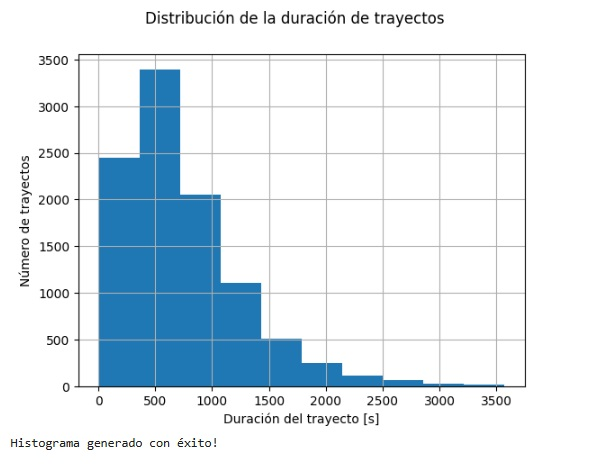

Describa la base de datos.

**¿Cuántos trayectos hay en la base de datos?**

10,000.

**¿Cómo describiría la distribución de la duración de los trayectos?**

Definitivamente no es una campana de gauss, la distribución que esta presenta es como una F de Fiser, donde la mayor frecuencia se encuentra con una duración en el trayecto con entre 0 y 1000s.

**¿Hay algo que debamos observar?**

Se tiene un promedio de 746s y los datos se encuentran con una damasida dispersión, siendo la desviación estandar 525 s

Asegúrese de que el histograma se muestra visible en el notebook.

# Entidades y relaciones

In [11]:
pickup_neighborhoods = pickup_neighborhoods.dropna(subset="neighborhood_id")
dropoff_neighborhoods = dropoff_neighborhoods.dropna(subset="neighborhood_id")

In [12]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

print('Entidades y relaciones definidas con éxito!')

Entidades y relaciones definidas con éxito!


# Primitivas de transformación

In [13]:
# ==============================================
# Listado de las primitivas creadas en este paso
trans_primitives = [IsWeekend]
# ==============================================


# This may take some time to compute
features = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de transformación definidas con éxito!')

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

Primitivas de transformación definidas con éxito!


Aquí hay algunos atributos que acabamos de crear:

In [14]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 10


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Finalmente, calculamos la matriz de atributos con dichos atributos:

In [15]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:239: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


,IS_WEEKEND(dropoff_datetime),payment_type,dropoff_neighborhoods.latitude,passenger_count,trip_distance,dropoff_neighborhoods.longitude,vendor_id,IS_WEEKEND(pickup_datetime),pickup_neighborhoods.longitude,pickup_neighborhoods.latitude
id,,,,,,,,,,
514030,True,1,40.766809,1,2.46,-73.956886,2,True,-73.986446,40.757707
514031,True,1,40.793597,2,7.90,-73.969822,1,True,-73.919159,40.744928
514032,True,1,40.740333,1,1.00,-74.005107,1,True,-73.991595,40.729652
514033,True,2,40.720245,1,0.02,-73.987205,2,True,-73.987205,40.720245
514034,True,1,40.785005,2,19.00,-73.976050,1,True,-73.785073,40.646194


In [16]:
feature_matrix.columns

Index(['IS_WEEKEND(dropoff_datetime)', 'payment_type',
       'dropoff_neighborhoods.latitude', 'passenger_count', 'trip_distance',
       'dropoff_neighborhoods.longitude', 'vendor_id',
       'IS_WEEKEND(pickup_datetime)', 'pickup_neighborhoods.longitude',
       'pickup_neighborhoods.latitude'],
      dtype='object')

# Primer modelo

In [17]:
# Separación de los datos de entrenamiento y prueba
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Dados separados com sucesso!')

Dados separados com sucesso!


In [18]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            3.30s
         2           0.4148            3.86s
         3           0.3661            3.07s
         4           0.3266            2.70s
         5           0.2934            3.02s
         6           0.2665            2.80s
         7           0.2441            2.78s
         8           0.2257            2.53s
         9           0.2103            2.33s
        10           0.1973            2.17s
        20           0.1435            1.53s
        30           0.1315            1.32s
        40           0.1262            1.02s
        50           0.1231            0.81s
        60           0.1209            0.61s
        70           0.1188            0.46s
        80           0.1167            0.32s
        90           0.1154            0.16s
       100           0.1139            0.00s
0.7562183415378823
Fase de entrenamiento realizada con éxito!


**<h1 style="color:red;">PREGUNTA 2: PRIMER MODELO</h1>**

Describa todos los atributos que hemos añadido al modelo. ¿Cree que han mejorado el desempeño respecto al modelo que no contaba con ellos? ¿Por qué?

*Su respuesta aqui - double click para editar*

In [19]:
# ==============================================
# Listado de las primitivas creadas en este paso
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, IsWeekend]
# ==============================================

features = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de tranformación definidas con éxito!')

Primitivas de tranformación definidas con éxito!


/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(


In [20]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 22


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [21]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:239: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


,WEEKDAY(pickup_datetime),WEEK(dropoff_datetime),passenger_count,WEEKDAY(dropoff_datetime),MINUTE(pickup_datetime),dropoff_neighborhoods.longitude,WEEK(pickup_datetime),IS_WEEKEND(dropoff_datetime),MONTH(pickup_datetime),HOUR(dropoff_datetime),...,DAY(dropoff_datetime),MINUTE(dropoff_datetime),trip_distance,payment_type,pickup_neighborhoods.latitude,DAY(pickup_datetime),vendor_id,pickup_neighborhoods.longitude,IS_WEEKEND(pickup_datetime),MONTH(dropoff_datetime)
id,,,,,,,,,,,,,,,,,,,,,
514030,5,13,1,5,0,-73.956886,13,True,4,0,...,2,17,2.46,1,40.757707,2,2,-73.986446,True,4
514031,5,13,2,5,0,-73.969822,13,True,4,0,...,2,24,7.90,1,40.744928,2,1,-73.919159,True,4
514032,5,13,1,5,0,-74.005107,13,True,4,0,...,2,19,1.00,1,40.729652,2,1,-73.991595,True,4
514033,5,13,1,5,0,-73.987205,13,True,4,0,...,2,1,0.02,2,40.720245,2,2,-73.987205,True,4
514034,5,13,2,5,1,-73.976050,13,True,4,0,...,2,58,19.00,1,40.646194,2,1,-73.785073,True,4


In [22]:
feature_matrix.columns

Index(['WEEKDAY(pickup_datetime)', 'WEEK(dropoff_datetime)', 'passenger_count',
       'WEEKDAY(dropoff_datetime)', 'MINUTE(pickup_datetime)',
       'dropoff_neighborhoods.longitude', 'WEEK(pickup_datetime)',
       'IS_WEEKEND(dropoff_datetime)', 'MONTH(pickup_datetime)',
       'HOUR(dropoff_datetime)', 'HOUR(pickup_datetime)',
       'dropoff_neighborhoods.latitude', 'DAY(dropoff_datetime)',
       'MINUTE(dropoff_datetime)', 'trip_distance', 'payment_type',
       'pickup_neighborhoods.latitude', 'DAY(pickup_datetime)', 'vendor_id',
       'pickup_neighborhoods.longitude', 'IS_WEEKEND(pickup_datetime)',
       'MONTH(dropoff_datetime)'],
      dtype='object')

In [23]:
# Volver a separar los datos
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Datos separados con éxito!')

Datos separados con éxito!


In [24]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.84s
         2           0.4148            1.87s
         3           0.3661            1.76s
         4           0.3264            2.12s
         5           0.2930            2.31s
         6           0.2660            2.46s
         7           0.2432            2.47s
         8           0.2245            2.40s
         9           0.2090            2.36s
        10           0.1960            2.28s
        20           0.1362            1.99s
        30           0.1202            1.97s
        40           0.1128            1.52s
        50           0.1082            1.21s
        60           0.1049            0.93s
        70           0.1027            0.68s
        80           0.1006            0.45s
        90           0.0962            0.23s
       100           0.0913            0.00s
0.8080396974822728
Fase de entrenamiento realizada con éxito!


**<h1 style="color:red;">PREGUNTA 3: SEGUNDO MODELO</h1>**

Describa el resto de nuevos atributos que acaba de añadir al modelo. ¿Cómo afectó esto al rendimiento del modelo? ¿Ha sido necesario sacrificar tiempo de entrenamiento?




*Su respuesta aqui - double click para editar*

# Primitivas de agregación

In [25]:
# ==============================================
# Listado de las primitivas creadas en este paso
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]
# ==============================================

features = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de tranformación definidas con éxito!')

Primitivas de tranformación definidas con éxito!


/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(


In [26]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 72


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.payment_type)>,
 <Feature: pickup_neighborhoods.MA

In [27]:
# Esto podría llevar cierto tiempo de computación, así que sea paciente
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:239: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress:   0%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:828: FutureWarning: The provided callable <function min at 0x79922fdf8dc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:828: FutureWarning: The provided callable <function mean at 0x79922fdf95a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:828: FutureWarning: The provided callable <function max at 0x79922fdf8ca0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable wil

Elapsed: 00:00 | Progress:   0%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:828: FutureWarning: The provided callable <function std at 0x79922fdf96c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:828: FutureWarning: The provided callable <function sum at 0x79922fdf8670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:828: FutureWarning: The provided callable <function max at 0x79922fdf8ca0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will b

Elapsed: 00:01 | Progress: 100%|██████████
Finishing computing...


,pickup_neighborhoods.MEAN(trips.trip_distance),dropoff_neighborhoods.MIN(trips.payment_type),dropoff_neighborhoods.SUM(trips.vendor_id),pickup_neighborhoods.latitude,dropoff_neighborhoods.MIN(trips.passenger_count),MINUTE(pickup_datetime),MONTH(pickup_datetime),pickup_neighborhoods.longitude,payment_type,dropoff_neighborhoods.MEAN(trips.vendor_id),...,dropoff_neighborhoods.MEDIAN(trips.trip_distance),pickup_neighborhoods.MIN(trips.payment_type),pickup_neighborhoods.MEAN(trips.passenger_count),dropoff_neighborhoods.longitude,pickup_neighborhoods.MEAN(trips.payment_type),dropoff_neighborhoods.latitude,WEEK(pickup_datetime),MINUTE(dropoff_datetime),dropoff_neighborhoods.STD(trips.passenger_count),trip_distance
id,,,,,,,,,,,,,,,,,,,,,
514030,2.930360,1.0,464.0,40.757707,1.0,0,4,-73.986446,1,1.572881,...,1.37,1.0,1.659910,-73.956886,1.488739,40.766809,13,17,1.313686,2.46
514031,3.107391,1.0,285.0,40.744928,1.0,0,4,-73.919159,1,1.574586,...,1.54,1.0,1.673913,-73.969822,1.543478,40.793597,13,24,1.266439,7.90
514032,2.366243,1.0,445.0,40.729652,1.0,0,4,-73.991595,1,1.518771,...,1.60,1.0,1.756757,-74.005107,1.262162,40.740333,13,19,1.311967,1.00
514033,3.037617,1.0,426.0,40.720245,1.0,0,4,-73.987205,2,1.510638,...,1.90,1.0,1.636364,-73.987205,1.228501,40.720245,13,1,1.307116,0.02
514034,16.229935,1.0,448.0,40.646194,1.0,1,4,-73.785073,1,1.529010,...,1.62,1.0,1.896104,-73.976050,1.396104,40.785005,13,58,1.248404,19.00


In [28]:
feature_matrix.columns

Index(['pickup_neighborhoods.MEAN(trips.trip_distance)',
       'dropoff_neighborhoods.MIN(trips.payment_type)',
       'dropoff_neighborhoods.SUM(trips.vendor_id)',
       'pickup_neighborhoods.latitude',
       'dropoff_neighborhoods.MIN(trips.passenger_count)',
       'MINUTE(pickup_datetime)', 'MONTH(pickup_datetime)',
       'pickup_neighborhoods.longitude', 'payment_type',
       'dropoff_neighborhoods.MEAN(trips.vendor_id)',
       'pickup_neighborhoods.STD(trips.passenger_count)',
       'dropoff_neighborhoods.MAX(trips.vendor_id)', 'passenger_count',
       'pickup_neighborhoods.SUM(trips.trip_distance)',
       'pickup_neighborhoods.STD(trips.payment_type)',
       'dropoff_neighborhoods.MAX(trips.payment_type)',
       'pickup_neighborhoods.MEAN(trips.vendor_id)',
       'dropoff_neighborhoods.MEDIAN(trips.passenger_count)',
       'pickup_neighborhoods.MIN(trips.trip_distance)',
       'dropoff_neighborhoods.COUNT(trips)',
       'pickup_neighborhoods.MIN(trips.passenger_co

In [29]:
# Volver a separar los datos
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Datos separados con éxito!')

Datos separados con éxito!


In [30]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            5.20s
         2           0.4148            6.44s
         3           0.3661            6.04s
         4           0.3264            5.77s
         5           0.2930            5.64s
         6           0.2660            6.27s
         7           0.2432            6.42s
         8           0.2245            6.72s
         9           0.2090            6.69s
        10           0.1960            6.68s
        20           0.1363            5.47s
        30           0.1198            4.44s
        40           0.1114            3.97s
        50           0.1063            3.17s
        60           0.1027            2.74s
        70           0.0999            2.32s
        80           0.0977            1.71s
        90           0.0953            0.88s
       100           0.0934            0.00s
0.7996990436007883
Fase de entrenamiento realizada con éxito!


# Evaluación con datos de prueba

In [31]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # deshaciendo el log calculado anteriormente
print('Cálculo de y_pred realizado con éxito!')

Cálculo de y_pred realizado con éxito!


In [32]:
# Mostrando las 5 primeras predicciones
y_pred[:5]

array([432.06429399, 669.00943141, 647.56334547, 628.35976187,
       418.15695184])

Histograma generado con éxito!!


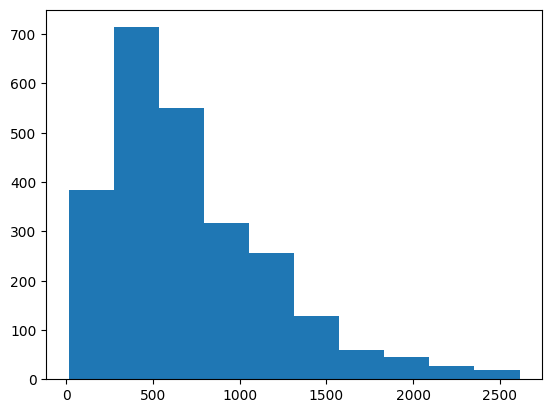

In [33]:
# Creando un histograma con todas ellas
matplotlib.pyplot.hist(y_pred)

print('Histograma generado con éxito!!')

**<h1 style="color:red;">PREGUNTA 4: PREDICCIONES DEL MODELO</h1>**

Analice las predicciones del modelo. ¿Coincide la distribución de los datos predichos con la distribución de los datos reales? ¿Qué otros atributos/estrategias podríamos usar para hacer nuestro modelo aún mejor, si tuvieramos más tiempo?





*Su respuesta aqui - double click para editar*

# Importancia de los atributos

In [34]:
feature_importances(model, feature_matrix.columns, n=25)

1: Feature: trip_distance, 0.867
2: Feature: dropoff_neighborhoods.longitude, 0.028
3: Feature: HOUR(pickup_datetime), 0.027
4: Feature: dropoff_neighborhoods.latitude, 0.022
5: Feature: HOUR(dropoff_datetime), 0.013
6: Feature: pickup_neighborhoods.longitude, 0.004
7: Feature: pickup_neighborhoods.COUNT(trips), 0.004
8: Feature: MINUTE(dropoff_datetime), 0.003
9: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
10: Feature: dropoff_neighborhoods.COUNT(trips), 0.002
11: Feature: pickup_neighborhoods.latitude, 0.002
12: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
13: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.002
14: Feature: MINUTE(pickup_datetime), 0.002
15: Feature: pickup_neighborhoods.MEAN(trips.payment_type), 0.002
16: Feature: pickup_neighborhoods.MEAN(trips.passenger_count), 0.002
17: Feature: dropoff_neighborhoods.MAX(trips.trip_distance), 0.001
18: Feature: dropoff_neighborhoods.MEAN(trips.passenger_count), 0.001
19: Feature: d

**<h1 style="color:red;">PREGUNTA 5: IMPORTANCIA DE LAS FEATURES</h1>**

Analice la importancia de los atributos que acaba de calcular. ¿Tienen sentido? ¿Hay algún valor que le sorprenda? Aporte una breve explicación de por qué estos atributos son relevante para calcular la variable objetivo `trip_duration` (duración del trayecto).

*Su respuesta aqui - double click para editar*

¡Buen trabajo! Asegúrese de comprobar la sección **Conclusión** del manual de instrucciones del caso de estudio.